In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

# Aquisição dos dados

|Country|Index|Ticker|
|---        |---        |---        |
|Brazil|iBovespa|^BVSP|
|USA|Nasdaq Composite|^IXIC|
|USA|NYSE Composite|^NYA|
|USA|Dow Jones|^DJI|
|Argentina|Merval|^MERV|
|Japan|Nikkei 225|^N225|
|China|Shangai Composite|000001.SS|
|China|Hang Seng|^HSI|
|India|BSE 30 Sensex|^BSESN|
|UK|FTSE 100|^FTSE|
|Sweden|Stockholm General|^OMX|
|Germany|Dax|^GDAXI|
|France|Cac 40|^FCHI|

In [2]:
dct = {"^BVSP": {"country":"Brazil", "continent":"America", "index_name": "iBovespa"},
"^IXIC": {"country":"USA", "continent":"America", "index_name": "Nasdaq"},
"^NYA": {"country":"USA", "continent":"America", "index_name": "NYSE"},
"^DJI": {"country":"USA", "continent":"America", "index_name": "DowJones"},
"^MERV": {"country":"Argentina", "continent":"America", "index_name": "Merval"},
"^N225": {"country":"Japan", "continent":"Asia", "index_name": "Nikkei"},
"000001.SS": { "country":"China", "continent":"Asia", "index_name": "Shangai"},
"^HSI": {"country":"China", "continent":"Asia", "index_name": "HangSeng"},
"^BSESN": {"country":"India", "continent":"Asia", "index_name": "BSE30Sensex"},
"^FTSE": {"country":"UK", "continent":"Europe", "index_name": "FTSE100"},
"^OMX": {"country":"Sweden", "continent":"Europe", "index_name": "StockholmGeneral"},
"^GDAXI": {"country":"Germany", "continent":"Europe", "index_name": "Dax"},
"^FCHI": {"country":"France", "continent":"Europe", "index_name": "Cac40"}}

def downloading_stocks_data(*, start_date: str="2011-01-01", end_date: str="2022-01-01") -> pd.DataFrame:
    lst_index = dct.keys()
    df = yf.download("^BVSP", start=start_date, end=end_date, show_errors=False)[["Close"]]
    df.columns = [dct["^BVSP"]["index_name"]]

    for market_index in list(dct.keys())[1:]:
        df_temp = yf.download(market_index, start=start_date, end=end_date)[["Close"]]
        df_temp.columns = [dct[market_index]["index_name"]]
        df = df.merge(df_temp, how='left', left_index=True, right_index=True)
    
    df.dropna(how='all', axis=0, inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    return df

df = downloading_stocks_data()
df.head(10)

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/guyrux/.pyenv/versions/3.8.5/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/guyrux/.pyenv/versions/3.8.5/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/guyrux/development/cafe_com_analytics/stock_market_index_daily_direction/.venv/lib/python3.8/site-packages/multitasking/__init__.py", line 102, in _run_via_pool
    return callee(*args, **kwargs)
  File "/home/guyrux/development/cafe_com_analytics/stock_market_index_daily_direction/.venv/lib/python3.8/site-packages/yfinance/multi.py", line 169, in _download_one_threaded
    data = _download_one(ticker, start, end, auto_adjust, back_adjust,
  File "/home/guyrux/development/cafe_com_analytics/stock_market_index_daily_direction/.venv/lib/python3.8/site-packages/yfinance/multi.py", line 181, in _download_one
    return Ticker(ticker).history(period=period, interval

KeyboardInterrupt: 

In [4]:
df_return_in_period = df.copy()

for column in df_return_in_period.columns:
    df_return_in_period[column] = df_return_in_period[column]/df_return_in_period.loc[min(df_return_in_period.index), column]

df_return_in_period.tail()

,iBovespa,Nasdaq,NYSE,DowJones,Merval,Nikkei,Shangai,HangSeng,BSE30Sensex,FTSE100,StockholmGeneral,Dax,Cac40
Date,,,,,,,,,,,,,
2021-06-17,1.830379,5.261469,2.040243,2.898138,18.310754,2.790734,1.235904,1.218575,2.544779,1.189478,1.931266,2.250108,1.708920
2021-06-18,1.835353,5.212809,2.006963,2.852437,17.951319,2.785517,1.235729,1.228930,2.545806,1.166880,1.910201,2.210102,1.684029
2021-06-21,1.847646,5.254087,2.040284,2.902724,17.951319,2.693851,1.237159,1.215606,2.556993,1.174329,1.925369,2.232306,1.692586
2021-06-22,1.840528,5.295621,2.044887,2.908603,18.162321,2.777828,1.247055,1.207958,2.557686,1.178935,1.927179,2.237040,1.694883
2021-06-23,1.835682,5.302481,2.043472,2.902490,18.162321,2.777828,1.247055,1.207958,2.543940,1.176285,1.905290,2.211297,1.679391


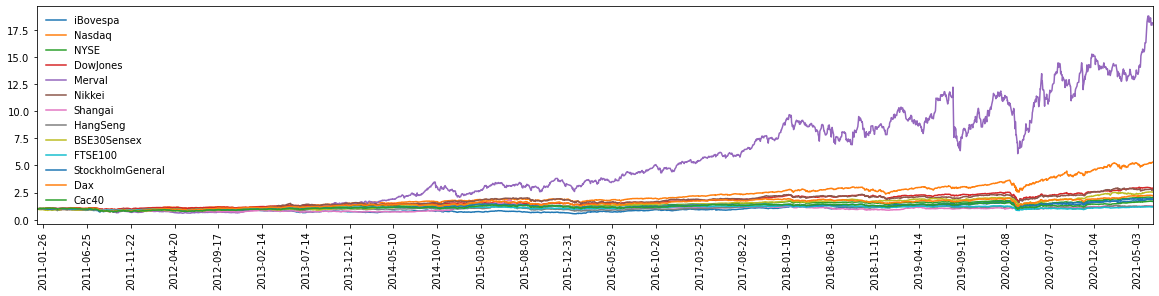

In [5]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)


for market_index in df_return_in_period.columns:
    ax.plot(df_return_in_period[market_index], label=market_index)

date_min = df_return_in_period.index.min()
date_max = df_return_in_period.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='upper left', frameon=False)
plt.xticks(rotation=90)
plt.show();

# Testando somente para iBovespa

## Preparação dos dados

Nesta seção, tomaremos as seguintes ações:

1. Separação do conjunto de dados de treinamento (01/01/2011 até 30/04/2021) e de validação do modelo (01/05/2021 até 30/05/2021).
1. Criação do atributo **"p/e"**: $ p/e = 100*(ln({r_{t}}) - ln({r_{t-1}})) $.
1. Criação da resposta **cluster** usando apenas a simples separação. Lembrando que no artigo, os autores compararam duas abordagens diferentes para discretizar a resposta ((a) simples separação e (b) Ward).

In [6]:
df_ibovespa = df[["iBovespa"]].copy()

X_train = df_ibovespa[:"2021-05-01"]
X_test = df_ibovespa["2021-05-01":]

print(f"""Base original: {df_ibovespa.shape}
X_train: {X_train.shape}
X_test: {X_test.shape}\n""")

# X_train["rt"] = (np.log(X_train["iBovespa"]) - np.log(X_train["iBovespa"].shift(periods=1)))*100
X_train["rt"] = (X_train["iBovespa"]-X_train["iBovespa"].shift(periods=1))/X_train["iBovespa"].shift(periods=1)
X_train = X_train[["iBovespa", "rt"]][1:]
X_train.head()

Base original: (2587, 1)
X_train: (2550, 1)
X_test: (37, 1)



,iBovespa,rt
Date,,
2011-01-04,70318.0,0.005088
2011-01-05,71091.0,0.010993
2011-01-06,70579.0,-0.007202
2011-01-07,70057.0,-0.007396
2011-01-10,70127.0,0.000999


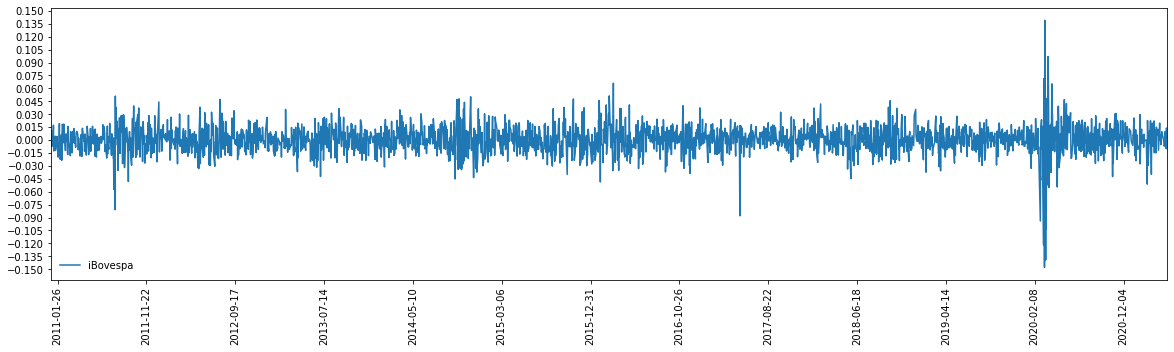

In [7]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

date_min = X_train.index.min()
date_max = X_train.index.max()

ax.plot(X_train['rt'], label="iBovespa")

ax.xaxis.set_major_locator(plt.MaxNLocator(13))
ax.yaxis.set_major_locator(plt.MaxNLocator(30))
# ax.set_ylim(-18, 18)
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

count    2549.000000
mean        0.000339
std         0.016138
min        -0.147797
25%        -0.008243
50%         0.000288
75%         0.009120
max         0.139082
Name: rt, dtype: float64

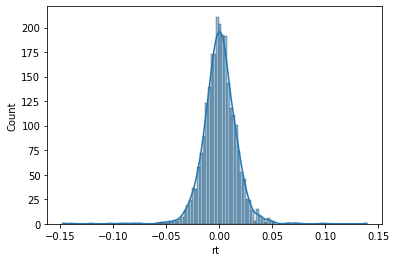

In [8]:
sns.histplot(data=X_train, x="rt", kde=True);
X_train['rt'].describe().T

### Agrupamento dos $r_{t}$

**Agrupamentos uniformes**

In [9]:
def uniform_clustering(df: pd.DataFrame, lst_columns: list) -> pd.DataFrame:
    """This function creates the target "Cluster" according to the limits described in article."""
    for column in lst_columns:
        desc = X_train['rt'].describe().T
        conditions  = [
            df[column] < desc["25%"],
            (df[column] >= desc["25%"]) & (df[column] < 0),
            (df[column] >= 0) & (df[column] < desc["75%"]),
            (df[column] >= desc["75%"])]
        choices = [ 1, 2, 3, 4]
        df["cluster_"+column] = np.select(conditions, choices, default=np.nan)

    return df

In [10]:
X_train = uniform_clustering(X_train, ["rt"])

round(X_train.groupby(by=["cluster_rt"]).agg({"rt": ["min", "max","count", "mean"]}), 2).reset_index()

cluster_rt    rt                  
               min   max count  mean
0        1.0 -0.15 -0.01   637 -0.02
1        2.0 -0.01 -0.00   611 -0.00
2        3.0  0.00  0.01   663  0.00
3        4.0  0.01  0.14   638  0.02

In [11]:
def create_rt_list(lst: list) -> list:
    rt = ["rt"]
    rt_ = ["rt-"+str(item) for item in lst]
    rt.extend(rt_)

    return rt

def create_shifted_rt(df: pd.DataFrame, rts: list) -> pd.DataFrame:
    for t in rts:
        df[f"rt-{t}"] = df["rt"].shift(periods=t)
    return df

In [12]:
X_train = df_ibovespa.loc[:"2021-05-01", ["iBovespa"]]
X_test = df_ibovespa.loc["2021-05-01":, ["iBovespa"]]

lst_shifts = np.arange(1,10,1)
lst_rts = create_rt_list(lst_shifts)

X_train["rt"] = (np.log(X_train["iBovespa"]) - np.log(X_train["iBovespa"].shift(periods=1)))*100
X_train = create_shifted_rt(X_train, lst_shifts)
X_train = uniform_clustering(X_train, lst_rts)

X_train.dropna(how='any', axis=0, inplace=True)
# X_train = X_train[["cluster_rt", "cluster_rt-1", "cluster_rt-5", "cluster_rt-37"]]
X_train.head(10)

,iBovespa,rt,rt-1,rt-2,rt-3,rt-4,rt-5,rt-6,rt-7,rt-8,...,cluster_rt,cluster_rt-1,cluster_rt-2,cluster_rt-3,cluster_rt-4,cluster_rt-5,cluster_rt-6,cluster_rt-7,cluster_rt-8,cluster_rt-9
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-17,70609.0,-0.467683,0.309189,-1.281330,1.703595,0.421203,0.099869,-0.742345,-0.722810,1.093293,...,2.0,3.0,1.0,4.0,3.0,3.0,2.0,2.0,4.0,3.0
2011-01-18,70920.0,0.439487,-0.467683,0.309189,-1.281330,1.703595,0.421203,0.099869,-0.742345,-0.722810,...,3.0,2.0,3.0,1.0,4.0,3.0,3.0,2.0,2.0,4.0
2011-01-19,70058.0,-1.222901,0.439487,-0.467683,0.309189,-1.281330,1.703595,0.421203,0.099869,-0.742345,...,1.0,3.0,2.0,3.0,1.0,4.0,3.0,3.0,2.0,2.0
2011-01-20,69562.0,-0.710503,-1.222901,0.439487,-0.467683,0.309189,-1.281330,1.703595,0.421203,0.099869,...,2.0,1.0,3.0,2.0,3.0,1.0,4.0,3.0,3.0,2.0
2011-01-21,69133.0,-0.618626,-0.710503,-1.222901,0.439487,-0.467683,0.309189,-1.281330,1.703595,0.421203,...,2.0,2.0,1.0,3.0,2.0,3.0,1.0,4.0,3.0,3.0
2011-01-24,69427.0,0.424366,-0.618626,-0.710503,-1.222901,0.439487,-0.467683,0.309189,-1.281330,1.703595,...,3.0,2.0,2.0,1.0,3.0,2.0,3.0,1.0,4.0,3.0
2011-01-26,68709.0,-1.039565,0.424366,-0.618626,-0.710503,-1.222901,0.439487,-0.467683,0.309189,-1.281330,...,1.0,3.0,2.0,2.0,1.0,3.0,2.0,3.0,1.0,4.0
2011-01-27,68051.0,-0.962277,-1.039565,0.424366,-0.618626,-0.710503,-1.222901,0.439487,-0.467683,0.309189,...,1.0,1.0,3.0,2.0,2.0,1.0,3.0,2.0,3.0,1.0
2011-01-28,66698.0,-2.008246,-0.962277,-1.039565,0.424366,-0.618626,-0.710503,-1.222901,0.439487,-0.467683,...,1.0,1.0,1.0,3.0,2.0,2.0,1.0,3.0,2.0,3.0


### Preparando conjunto de validação


In [13]:
X_test = df_ibovespa.loc["2021-01-01":, ["iBovespa"]]

X_test["rt"] = (np.log(X_test["iBovespa"]) - np.log(X_test["iBovespa"].shift(periods=1)))*100
X_test = create_shifted_rt(X_test, lst_shifts)
X_test = uniform_clustering(X_test, lst_rts)


X_test = X_test["2021-05-01":]
X_test.head(10)


,iBovespa,rt,rt-1,rt-2,rt-3,rt-4,rt-5,rt-6,rt-7,rt-8,...,cluster_rt,cluster_rt-1,cluster_rt-2,cluster_rt-3,cluster_rt-4,cluster_rt-5,cluster_rt-6,cluster_rt-7,cluster_rt-8,cluster_rt-9
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-03,119209.0,0.264592,-0.980925,-0.818687,1.384977,-1.005913,0.053914,0.966239,-0.577199,-0.723667,...,3.0,1.0,2.0,4.0,1.0,3.0,4.0,2.0,2.0,2.0
2021-05-04,117712.0,-1.263729,0.264592,-0.980925,-0.818687,1.384977,-1.005913,0.053914,0.966239,-0.577199,...,1.0,3.0,1.0,2.0,4.0,1.0,3.0,4.0,2.0,2.0
2021-05-05,119564.0,1.561083,-1.263729,0.264592,-0.980925,-0.818687,1.384977,-1.005913,0.053914,0.966239,...,4.0,1.0,3.0,1.0,2.0,4.0,1.0,3.0,4.0,2.0
2021-05-06,119921.0,0.298140,1.561083,-1.263729,0.264592,-0.980925,-0.818687,1.384977,-1.005913,0.053914,...,3.0,4.0,1.0,3.0,1.0,2.0,4.0,1.0,3.0,4.0
2021-05-07,122038.0,1.749928,0.298140,1.561083,-1.263729,0.264592,-0.980925,-0.818687,1.384977,-1.005913,...,4.0,3.0,4.0,1.0,3.0,1.0,2.0,4.0,1.0,3.0
2021-05-10,121909.0,-0.105761,1.749928,0.298140,1.561083,-1.263729,0.264592,-0.980925,-0.818687,1.384977,...,2.0,4.0,3.0,4.0,1.0,3.0,1.0,2.0,4.0,1.0
2021-05-11,122964.0,0.861676,-0.105761,1.749928,0.298140,1.561083,-1.263729,0.264592,-0.980925,-0.818687,...,3.0,2.0,4.0,3.0,4.0,1.0,3.0,1.0,2.0,4.0
2021-05-12,119710.0,-2.681948,0.861676,-0.105761,1.749928,0.298140,1.561083,-1.263729,0.264592,-0.980925,...,1.0,3.0,2.0,4.0,3.0,4.0,1.0,3.0,1.0,2.0
2021-05-13,120706.0,0.828569,-2.681948,0.861676,-0.105761,1.749928,0.298140,1.561083,-1.263729,0.264592,...,3.0,1.0,3.0,2.0,4.0,3.0,4.0,1.0,3.0,1.0


## Treinando um modelo

Vamos testar primeiro um Naive Bayes:

In [14]:
model = GaussianNB()
model.fit(X_train[lst_rts[1:]], X_train["cluster_rt"])

GaussianNB()

### Prevendo e avaliando preliminarmente

Primeiro, vamos ver como fica a acurácia e a proporção de acertos por classe.

In [15]:
y_pred = model.predict(X_test[lst_rts[1:]])
X_test_ = X_test.copy()
# X_test_ = X_test_[["rt", "rt-1", "rt-5", "rt-37"]]
X_test_["y_pred"] = y_pred

X_test_

,iBovespa,rt,rt-1,rt-2,rt-3,rt-4,rt-5,rt-6,rt-7,rt-8,...,cluster_rt-1,cluster_rt-2,cluster_rt-3,cluster_rt-4,cluster_rt-5,cluster_rt-6,cluster_rt-7,cluster_rt-8,cluster_rt-9,y_pred
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-03,119209.000000,0.264592,-0.980925,-0.818687,1.384977,-1.005913,0.053914,0.966239,-0.577199,-0.723667,...,1.0,2.0,4.0,1.0,3.0,4.0,2.0,2.0,2.0,3.0
2021-05-04,117712.000000,-1.263729,0.264592,-0.980925,-0.818687,1.384977,-1.005913,0.053914,0.966239,-0.577199,...,3.0,1.0,2.0,4.0,1.0,3.0,4.0,2.0,2.0,3.0
2021-05-05,119564.000000,1.561083,-1.263729,0.264592,-0.980925,-0.818687,1.384977,-1.005913,0.053914,0.966239,...,1.0,3.0,1.0,2.0,4.0,1.0,3.0,4.0,2.0,3.0
2021-05-06,119921.000000,0.298140,1.561083,-1.263729,0.264592,-0.980925,-0.818687,1.384977,-1.005913,0.053914,...,4.0,1.0,3.0,1.0,2.0,4.0,1.0,3.0,4.0,2.0
2021-05-07,122038.000000,1.749928,0.298140,1.561083,-1.263729,0.264592,-0.980925,-0.818687,1.384977,-1.005913,...,3.0,4.0,1.0,3.0,1.0,2.0,4.0,1.0,3.0,3.0
2021-05-10,121909.000000,-0.105761,1.749928,0.298140,1.561083,-1.263729,0.264592,-0.980925,-0.818687,1.384977,...,4.0,3.0,4.0,1.0,3.0,1.0,2.0,4.0,1.0,3.0
2021-05-11,122964.000000,0.861676,-0.105761,1.749928,0.298140,1.561083,-1.263729,0.264592,-0.980925,-0.818687,...,2.0,4.0,3.0,4.0,1.0,3.0,1.0,2.0,4.0,2.0
2021-05-12,119710.000000,-2.681948,0.861676,-0.105761,1.749928,0.298140,1.561083,-1.263729,0.264592,-0.980925,...,3.0,2.0,4.0,3.0,4.0,1.0,3.0,1.0,2.0,3.0
2021-05-13,120706.000000,0.828569,-2.681948,0.861676,-0.105761,1.749928,0.298140,1.561083,-1.263729,0.264592,...,1.0,3.0,2.0,4.0,3.0,4.0,1.0,3.0,1.0,3.0


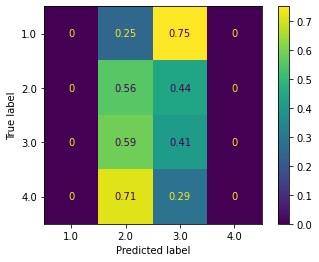

In [16]:
plot_confusion_matrix(model, X_test_[lst_rts[1:]], X_test_["cluster_rt"], normalize='true');

In [17]:
accuracy_score(X_test_["cluster_rt"], y_pred, normalize=True)

0.32432432432432434

In [18]:
X_test_.tail()

,iBovespa,rt,rt-1,rt-2,rt-3,rt-4,rt-5,rt-6,rt-7,rt-8,...,cluster_rt-1,cluster_rt-2,cluster_rt-3,cluster_rt-4,cluster_rt-5,cluster_rt-6,cluster_rt-7,cluster_rt-8,cluster_rt-9,y_pred
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-17,128057.000000,-0.934267,-0.641606,-0.089897,0.590799,-0.489372,0.130009,0.092416,-0.759129,0.498272,...,2.0,2.0,3.0,2.0,3.0,3.0,2.0,3.0,3.0,2.0
2021-06-18,128405.000000,0.271385,-0.934267,-0.641606,-0.089897,0.590799,-0.489372,0.130009,0.092416,-0.759129,...,1.0,2.0,2.0,3.0,2.0,3.0,3.0,2.0,3.0,2.0
2021-06-21,129265.000000,0.667523,0.271385,-0.934267,-0.641606,-0.089897,0.590799,-0.489372,0.130009,0.092416,...,3.0,1.0,2.0,2.0,3.0,2.0,3.0,3.0,2.0,3.0
2021-06-22,128767.000000,-0.385999,0.667523,0.271385,-0.934267,-0.641606,-0.089897,0.590799,-0.489372,0.130009,...,3.0,3.0,1.0,2.0,2.0,3.0,2.0,3.0,3.0,3.0
2021-06-23,128427.976562,-0.263632,-0.385999,0.667523,0.271385,-0.934267,-0.641606,-0.089897,0.590799,-0.489372,...,2.0,3.0,3.0,1.0,2.0,2.0,3.0,2.0,3.0,3.0


In [19]:
rt_mean = round(X_train.groupby(by=["cluster_rt"]).agg({"rt": ["min", "max","count", "mean"]}), 2)[("rt", "mean")]
rt_mean
conditions = [X_test_["y_pred"]==1.0, X_test_["y_pred"]==2.0, X_test_["y_pred"]==3.0, X_test_["y_pred"]==4.0]
choices = rt_mean.tolist()
X_test_["rt_predict"] = np.select(conditions, choices, default=np.nan)

rmse_uniform = mean_squared_error(X_test_["rt"], X_test_["rt_predict"], squared=False)
print(f"RMSE para esse método: {round(rmse_uniform, 4)}%")

RMSE para esse método: 1.0359%


# Modelo impondo a estrutura

In [29]:
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from IPython.core.display import display, HTML
from pgmpy.models import BayesianModel

model = BayesianModel([('cluster_rt-37', 'cluster_rt'), ('cluster_rt-5', 'cluster_rt'), ('cluster_rt-1', 'cluster_rt')])

# # disable text wrapping in output cell
# display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

lst_cluster = [column for column in X_train_network.columns if 'cluster_' in column]

model.cpds = []
model.fit(X_train_network[lst_cluster],
          estimator=BayesianEstimator,
          prior_type="k2",
          equivalent_sample_size=10,
          complete_samples_only=False)

# RMSE

In [45]:
X_test_network = df_ibovespa[["iBovespa"]].copy()
X_test_network["rt"] = (np.log(X_test_network["iBovespa"]) - np.log(X_test_network["iBovespa"].shift(periods=1)))*100
# X_test_network["2021-06-01":].tail()
X_test_network = create_shifted_rt(X_test_network, [1, 5, 37])
X_test_network = uniform_clustering(X_test_network, ["rt", "rt-1", "rt-5", "rt-37"])
X_test_network.tail(20)

,iBovespa,rt,rt-1,rt-5,rt-37,cluster_rt,cluster_rt-1,cluster_rt-5,cluster_rt-37
Date,,,,,,,,,
2021-05-26,123989.000000,0.810606,-0.845281,-0.280112,-1.191111,3.0,1.0,2.0,1.0
2021-05-27,124367.000000,0.304402,0.810606,0.052988,1.946180,3.0,3.0,3.0,4.0
2021-05-28,125561.000000,0.955482,0.304402,-0.088873,-0.016169,4.0,3.0,2.0,2.0
2021-05-31,126216.000000,0.520303,0.955482,1.167783,0.106327,3.0,4.0,4.0,3.0
2021-06-01,128267.000000,1.611930,0.520303,-0.845281,0.584056,4.0,3.0,1.0,3.0
2021-06-02,129601.000000,1.034647,1.611930,0.810606,-0.544956,4.0,4.0,3.0,2.0
2021-06-04,130126.000000,0.404271,1.034647,0.304402,0.965832,3.0,4.0,3.0,4.0
2021-06-07,130776.000000,0.498272,0.404271,0.955482,0.407377,3.0,3.0,4.0,3.0
2021-06-08,129787.000000,-0.759129,0.498272,0.520303,0.833088,2.0,3.0,3.0,3.0


In [46]:
def predict_model(model, evidence:dict):
    infer = VariableElimination(model)
    proba_predicted = infer.query(['cluster_rt'], evidence=evidence)
    valued_predicted = infer.map_query(['cluster_rt'], evidence=evidence)
    return (valued_predicted, proba_predicted)

from pgmpy.inference import VariableElimination

resultado = {}

for i, item in enumerate(X_test_network["2021-06-01":].index):
    evidence = {
        'cluster_rt-37': X_test_network.loc[item]['cluster_rt-37'],
        'cluster_rt-5': X_test_network.loc[item]['cluster_rt-5'],
        'cluster_rt-1': X_test_network.loc[item]['cluster_rt-1']
        }
    
    predict = predict_model(model, evidence=evidence)

    resultado[item] = [predict[0]['cluster_rt'], X_test_network.loc[item]['cluster_rt'], X_test_network.loc[item]['rt']]

resultado = pd.DataFrame.from_dict(resultado, orient='index')

resultado.rename(columns={0: 'y_pred', 1: 'cluster_rt', 2:'rt'}, inplace=True)


# resultado

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimina

In [47]:
resultado["y_pred"].unique()

array([4., 3., 1., 2.])

In [49]:
conditions = [
    resultado["y_pred"]==1.0, resultado["y_pred"]==2.0, resultado["y_pred"]==3.0, resultado["y_pred"]==4.0]
choices = rt_mean.tolist()
resultado["rt_predict"] = np.select(conditions, choices)

rmse_uniform = mean_squared_error(resultado["rt"], resultado["rt_predict"], squared=False)

print(f"RMSE para esse método: {round(rmse_uniform, 4)}%")

RMSE para esse método: 1.2635%


In [50]:
resultado = resultado.round(3)
resultado.tail()

,y_pred,cluster_rt,rt,rt_predict
2021-06-17,2.0,1.0,-0.934,-0.39
2021-06-18,4.0,3.0,0.271,1.88
2021-06-21,1.0,3.0,0.668,-1.88
2021-06-22,1.0,2.0,-0.386,-1.88
2021-06-23,1.0,2.0,-0.264,-1.88


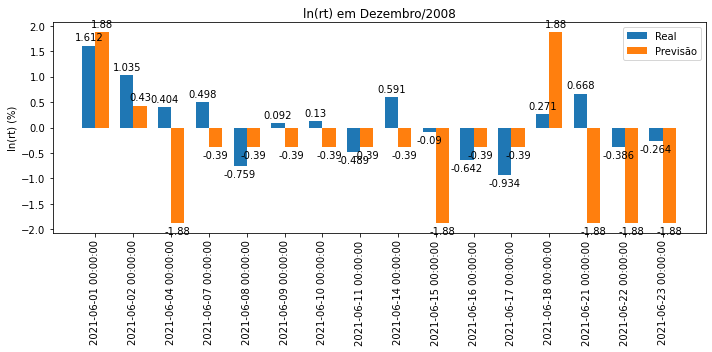

In [51]:

x = np.arange(len(resultado)) 
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, resultado['rt'], width, label='Real')
rects2 = ax.bar(x + width/2, resultado['rt_predict'], width, label='Previsão')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('ln(rt) (%)')
ax.set_title('ln(rt) em Dezembro/2008')
ax.set_xticks(x)
ax.set_xticklabels(resultado.index)
plt.xticks(rotation=90)

ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## Achando a estrutura da rede

In [26]:
# sequencia = np.arange(1, 15, 2)
sequencia = [1,5,37]
sequencia_rt = list(["rt-"+str(_) for _ in sequencia][::-1])
sequencia_rt.append('rt')

print(f"""\nTamanho da sequência: {len(sequencia)}
Sequência: {sequencia_rt}""")


Tamanho da sequência: 3
Sequência: ['rt-37', 'rt-5', 'rt-1', 'rt']


In [27]:
X_train_network = X_train[["rt"]].copy()
X_train_network = create_shifted_rt(X_train_network, sequencia)
X_train_network = uniform_clustering(X_train_network, sequencia_rt)

X_train_network.dropna(how="any", axis=0, inplace=True)
# X_train_network = X_train_network.sample(100, random_state=0).copy()
X_train_network = X_train_network.iloc[-200:,]
X_train_network = X_train_network[[column for column in X_train_network.columns if 'cluster_' in column]]

print(f"Tamanho: {X_train_network.shape}")

X_train_network.tail(10)

Tamanho: (200, 4)


,cluster_rt-37,cluster_rt-5,cluster_rt-1,cluster_rt
Date,,,,
2021-04-16,4.0,2.0,3.0,3.0
2021-04-19,3.0,4.0,3.0,2.0
2021-04-20,1.0,3.0,2.0,2.0
2021-04-22,1.0,3.0,2.0,2.0
2021-04-23,3.0,3.0,2.0,4.0
2021-04-26,4.0,3.0,4.0,3.0
2021-04-27,2.0,2.0,3.0,1.0
2021-04-28,4.0,2.0,1.0,4.0
2021-04-29,4.0,2.0,4.0,2.0


### Considerando que as variáveis impactam diretamente o target

Ou seja:
(rt-x -> rt), (rt-y -> rt), (rt-z -> rt)...


In [21]:
lst_sequence = []

for column in X_train_network.columns[:-1]:
    lst_sequence.append((column, "cluster_rt"))

lst_sequence

[('cluster_rt-13', 'cluster_rt'),
 ('cluster_rt-11', 'cluster_rt'),
 ('cluster_rt-9', 'cluster_rt'),
 ('cluster_rt-7', 'cluster_rt'),
 ('cluster_rt-5', 'cluster_rt'),
 ('cluster_rt-3', 'cluster_rt'),
 ('cluster_rt-1', 'cluster_rt')]

In [22]:
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel

k2 = K2Score(X_train_network)

lst_temp = []
selected_columns = ["cluster_rt"]
df_result = pd.DataFrame(columns=["k2", "variables"])

for i, item in enumerate(lst_sequence):
    lst_temp.append(lst_sequence[len(lst_sequence)-i-1])
    selected_columns.append(lst_sequence[len(lst_sequence)-i-1][0])

    k2 = K2Score(X_train_network[selected_columns])
    model1 = BayesianModel(lst_temp)
    df_result.loc[i, "k2"] = k2.score(model1)
    df_result.loc[i, "variables"] = str(lst_temp)

df_result.sort_values(by="k2", ascending=False)

,k2,variables
0,-567.592368,"[('cluster_rt-1', 'cluster_rt')]"
1,-861.204781,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
2,-1129.76713,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
3,-1406.131118,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
4,-1686.535663,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
5,-1969.4434,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
6,-2251.140553,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."


### Considerando que as variáveis impactam a seguinte

Ou seja:
(rt-10 -> rt-9), (rt-9 -> rt-8), (rt-8 -> rt-7)...

In [23]:
X_train_network

,cluster_rt-13,cluster_rt-11,cluster_rt-9,cluster_rt-7,cluster_rt-5,cluster_rt-3,cluster_rt-1,cluster_rt
Date,,,,,,,,
2020-07-07,3.0,1.0,1.0,1.0,2.0,3.0,4.0,1.0
2020-07-08,3.0,3.0,4.0,4.0,4.0,3.0,1.0,4.0
2020-07-09,1.0,1.0,1.0,2.0,3.0,4.0,4.0,2.0
2020-07-10,3.0,4.0,4.0,4.0,3.0,1.0,2.0,3.0
2020-07-13,1.0,1.0,2.0,3.0,4.0,4.0,3.0,1.0
...,...,...,...,...,...,...,...,...
2021-04-26,2.0,3.0,4.0,3.0,3.0,2.0,4.0,3.0
2021-04-27,3.0,2.0,3.0,3.0,2.0,2.0,3.0,1.0
2021-04-28,3.0,4.0,3.0,3.0,2.0,4.0,1.0,4.0


In [24]:
lst_sequence = []
n = len(X_train_network.columns)-1

for i, column in enumerate(X_train_network.columns[::-1]):
    lst_sequence.append((X_train_network.columns[n-(1+i)], X_train_network.columns[n-i]))

lst_sequence.pop()

('cluster_rt', 'cluster_rt-13')

In [25]:
k2 = K2Score(X_train_network)

lst_temp = []
df_result = pd.DataFrame(columns=["k2", "variables"])

for i, item in enumerate(lst_sequence):
    lst_temp.append(lst_sequence[i])
    print(lst_temp)
    k2 = K2Score(X_train_network)
    model1 = BayesianModel(lst_temp)
    df_result.loc[i, "k2"] = k2.score(model1)
    df_result.loc[i, "variables"] = str(lst_temp)

df_result.sort_values(by="k2", ascending=False)

[('cluster_rt-1', 'cluster_rt')]
[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-3', 'cluster_rt-1')]
[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-3', 'cluster_rt-1'), ('cluster_rt-5', 'cluster_rt-3')]
[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-3', 'cluster_rt-1'), ('cluster_rt-5', 'cluster_rt-3'), ('cluster_rt-7', 'cluster_rt-5')]
[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-3', 'cluster_rt-1'), ('cluster_rt-5', 'cluster_rt-3'), ('cluster_rt-7', 'cluster_rt-5'), ('cluster_rt-9', 'cluster_rt-7')]
[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-3', 'cluster_rt-1'), ('cluster_rt-5', 'cluster_rt-3'), ('cluster_rt-7', 'cluster_rt-5'), ('cluster_rt-9', 'cluster_rt-7'), ('cluster_rt-11', 'cluster_rt-9')]
[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-3', 'cluster_rt-1'), ('cluster_rt-5', 'cluster_rt-3'), ('cluster_rt-7', 'cluster_rt-5'), ('cluster_rt-9', 'cluster_rt-7'), ('cluster_rt-11', 'cluster_rt-9'), ('cluster_rt-13', 'cluster_rt-11')]


,k2,variables
0,-567.592368,"[('cluster_rt-1', 'cluster_rt')]"
1,-856.553284,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
2,-1144.887749,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
3,-1433.637773,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
4,-1721.321015,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
5,-2009.072078,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."
6,-2297.025232,"[('cluster_rt-1', 'cluster_rt'), ('cluster_rt-..."


# Reproduzindo Malagrino

## Primeiro, vamos testar o conjunto de índices que obtiveram o melhor resultado no artigo com atraso de 24h:

- NYSE,
- Cac 40,
- Hang Seng

In [29]:
df.head()

,iBovespa,Nasdaq,NYSE,DowJones,Merval,Nikkei,Shangai,HangSeng,BSE30Sensex,FTSE100,StockholmGeneral,Dax,Cac40
Date,,,,,,,,,,,,,
2011-01-03,69962.0,2691.520020,8043.970215,11670.750000,3628.479980,10398.099609,2852.647949,23436.050781,20561.050781,6013.899902,1176.849976,6989.740234,3900.860107
2011-01-04,70318.0,2681.250000,8022.180176,11691.179688,3613.729980,10398.099609,2852.647949,23668.480469,20498.720703,6013.899902,1165.880005,6975.350098,3916.030029
2011-01-05,71091.0,2702.199951,8040.040039,11722.889648,3604.800049,10380.769531,2839.220947,23757.820312,20301.099609,6043.899902,1151.800049,6939.819824,3904.610107
2011-01-06,70579.0,2709.889893,8000.899902,11697.309570,3603.439941,10529.759766,2824.197021,23786.300781,20184.740234,6019.500000,1151.800049,6981.390137,3904.419922
2011-01-07,70057.0,2703.169922,7980.319824,11674.759766,3546.260010,10541.040039,2838.801025,23686.630859,19691.810547,5984.299805,1159.449951,6947.839844,3865.580078


In [30]:
df_malagrino = df[['iBovespa', 'NYSE', 'Cac40','HangSeng']].copy()

for column in ['iBovespa', 'NYSE', 'Cac40','HangSeng']:
    df_malagrino[column] = (df_malagrino[column]-df_malagrino[column].shift(periods=1))/df_malagrino[column].shift(periods=1)
    df_malagrino[column+"_dicretizado"] = np.where(df_malagrino[column]>0,1,0)
    df_malagrino[column+"_24h"] = df_malagrino[column].shift(periods=1)

df_malagrino.head(100)

,iBovespa,NYSE,Cac40,HangSeng,iBovespa_dicretizado,iBovespa_24h,NYSE_dicretizado,NYSE_24h,Cac40_dicretizado,Cac40_24h,HangSeng_dicretizado,HangSeng_24h
Date,,,,,,,,,,,,
2011-01-03,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN
2011-01-04,0.005088,-0.002709,0.003889,0.009918,1,NaN,0,NaN,1,NaN,1,NaN
2011-01-05,0.010993,0.002226,-0.002916,0.003775,1,0.005088,1,-0.002709,0,0.003889,1,0.009918
2011-01-06,-0.007202,-0.004868,-0.000049,0.001199,0,0.010993,0,0.002226,0,-0.002916,1,0.003775
2011-01-07,-0.007396,-0.002572,-0.009948,-0.004190,0,-0.007202,0,-0.004868,0,-0.000049,0,0.001199
...,...,...,...,...,...,...,...,...,...,...,...,...
2011-05-23,-0.004026,-0.014476,-0.021016,-0.021051,0,0.003688,0,-0.008356,0,-0.009159,0,0.001555
2011-05-24,0.015911,0.001932,0.002534,0.000870,1,-0.004026,1,-0.014476,1,-0.021016,1,-0.021051
2011-05-25,0.000805,0.005200,0.003092,0.000726,1,0.015911,1,0.001932,1,0.002534,1,0.000870


In [31]:
df_temp = df_malagrino[["iBovespa_dicretizado", "NYSE_dicretizado", "Cac40_dicretizado", "HangSeng_dicretizado"]]
df_temp.head(20)
df_temp.to_excel("proporcao.xlsx")

ModuleNotFoundError: No module named 'xlwt'